# CCB2 - Rating Prediction with Rating Regression Head

## Strategy (Improved from CCB2)
- **Ground Truth**: Rating >= 4 = Positive (good purchases only)
- **Task**: **Predict actual rating values (0.5 ~ 5.0)** and recommend if rating >= 4
- **Graph**: Rating-weighted bipartite graph
- **Model**: LightGCN + **Rating Prediction MLP Head** (NEW!)
- **Loss**: **Hybrid Loss = BPR + MSE** (NEW!)
  - BPR Loss: Ranking learning
  - MSE Loss: Rating value prediction
- **Evaluation**: AUC-ROC, F1, Precision, Recall, **Rating RMSE/MAE** (NEW!)
- **Recommendation**: Rating-based (if predicted_rating >= 4.0 → O)

## Key Improvements from ccb2:
- ✅ **Direct rating prediction** (not just scoring)
- ✅ Rating MLP Head added to LightGCN
- ✅ Hybrid Loss for better learning
- ✅ Test set doesn't need rating column
- ✅ Interpretable: "This item will get 4.2 stars"

## Expected Performance:
- AUC-ROC: **0.94+** (vs ccb2 0.927)
- Rating RMSE: **0.5 ~ 0.7** (new metric)
- F1: **0.88+** (vs ccb2 0.872)
- More accurate and interpretable recommendations

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')
import time

import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device setup (CUDA > MPS > CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Device: {device} ({torch.cuda.get_device_name()})')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f'Device: {device}')
else:
    device = torch.device('cpu')
    print(f'Device: {device}')

Device: mps


## 1. Data Preprocessing

### B ver Strategy:
- **Positive**: Rating >= 4 (good purchases)
- **Negative**: Rating < 4 (poor purchases) + non-interactions
- **Graph construction**: All edges (rating < 4 helps structure learning)
- **Evaluation**: Only rating >= 4 as ground truth

In [16]:
df = pd.read_csv('../data/train.csv')

print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user'].nunique()}")
print(f"Unique items: {df['item'].nunique()}")
print(f"\nRating distribution:")
print(df['rating'].value_counts().sort_index())

# Define good purchases
GOOD_RATING_THRESHOLD = 4
n_good_purchases = (df['rating'] >= GOOD_RATING_THRESHOLD).sum()
print(f"\nGood purchases (rating >= {GOOD_RATING_THRESHOLD}): {n_good_purchases:,} ({100*n_good_purchases/len(df):.1f}%)")

# ID mapping
user2idx = {u: i for i, u in enumerate(sorted(df['user'].unique()))}
item2idx = {it: i for i, it in enumerate(sorted(df['item'].unique()))}
idx2user = {i: u for u, i in user2idx.items()}
idx2item = {i: it for it, i in item2idx.items()}

n_users, n_items = len(user2idx), len(item2idx)

df['user_idx'] = df['user'].map(user2idx)
df['item_idx'] = df['item'].map(item2idx)

print(f"\nUsers: {n_users}, Items: {n_items}")
print(f"Sparsity: {(1 - len(df) / (n_users * n_items)) * 100:.4f}%")

Total interactions: 105,139
Unique users: 668
Unique items: 10321

Rating distribution:
rating
0.5     1189
1.0     3254
1.5     1564
2.0     7929
2.5     5473
3.0    21676
3.5    12224
4.0    28831
4.5     8174
5.0    14825
Name: count, dtype: int64

Good purchases (rating >= 4): 51,830 (49.3%)

Users: 668, Items: 10321
Sparsity: 98.4750%


In [17]:
# User별 interaction count 및 K값 계산
user_interaction_count = df.groupby('user_idx').size().to_dict()

MAX_K = 100  # K 상한선

def get_k_for_user(count):
    """User별 추천 개수 K 계산 (평가 규칙: 20% 이하 추천)"""
    if count <= 10:
        return 2  # Cold user: 무조건 2개
    k = max(2, int(count * 0.2))
    return min(k, MAX_K)

user_k = {u: get_k_for_user(c) for u, c in user_interaction_count.items()}

# 통계
k_values = list(user_k.values())
print(f"User K values statistics (MAX_K={MAX_K}):")
print(f"  Min K: {min(k_values)}")
print(f"  Max K: {max(k_values)}")
print(f"  Mean K: {np.mean(k_values):.2f}")
print(f"  Median K: {np.median(k_values):.2f}")

cold_users = sum(1 for c in user_interaction_count.values() if c <= 10)
print(f"\nCold users (≤10 interactions): {cold_users} ({100*cold_users/n_users:.1f}%)")

User K values statistics (MAX_K=100):
  Min K: 4
  Max K: 100
  Mean K: 24.74
  Median K: 14.00

Cold users (≤10 interactions): 0 (0.0%)


## 2. Train/Val/Test Split

### B ver Split (V9b approach):
- **Good purchases (rating >= 4)**: Split into train/val/test (7:1.5:1.5)
- **Poor purchases (rating < 4)**: All go to train (for graph structure)
- **Evaluation**: Only on rating >= 4 (quality-focused)

In [18]:
# Train/Val/Test Split (70/15/15) - Rating-aware
train_data, val_data, test_data = [], [], []

for user_idx in range(n_users):
    user_df = df[df['user_idx'] == user_idx]
    
    # Separate good and poor purchases
    good_purchases = user_df[user_df['rating'] >= GOOD_RATING_THRESHOLD][['user_idx', 'item_idx', 'rating']]
    bad_purchases = user_df[user_df['rating'] < GOOD_RATING_THRESHOLD][['user_idx', 'item_idx', 'rating']]
    
    # Poor purchases → all to train (for graph learning, not evaluation)
    if len(bad_purchases) > 0:
        train_data.append(bad_purchases[['user_idx', 'item_idx']])
    
    # Good purchases → split into train/val/test
    n_good = len(good_purchases)
    
    if n_good >= 3:
        good_purchases = good_purchases.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_end = int(0.7 * n_good)
        val_end = train_end + int(0.15 * n_good)
        
        train_end = max(1, train_end)
        val_end = max(train_end + 1, val_end)
        
        train_data.append(good_purchases.iloc[:train_end][['user_idx', 'item_idx']])
        val_data.append(good_purchases.iloc[train_end:val_end][['user_idx', 'item_idx']])
        test_data.append(good_purchases.iloc[val_end:][['user_idx', 'item_idx']])
    elif n_good == 2:
        good_purchases = good_purchases.sample(frac=1, random_state=SEED).reset_index(drop=True)
        train_data.append(good_purchases.iloc[:1][['user_idx', 'item_idx']])
        val_data.append(good_purchases.iloc[1:][['user_idx', 'item_idx']])
    elif n_good == 1:
        train_data.append(good_purchases[['user_idx', 'item_idx']])

train_df = pd.concat(train_data, ignore_index=True)
val_df = pd.concat(val_data, ignore_index=True) if val_data else pd.DataFrame(columns=['user_idx', 'item_idx'])
test_df = pd.concat(test_data, ignore_index=True) if test_data else pd.DataFrame(columns=['user_idx', 'item_idx'])

print(f"Train edges (all purchases for graph): {len(train_df):,}")
print(f"Val edges (good purchases only): {len(val_df):,}")
print(f"Test edges (good purchases only): {len(test_df):,}")

n_val_test = len(val_df) + len(test_df)
print(f"\nGood purchases in Val/Test: {n_val_test:,} / {n_good_purchases:,} ({100*n_val_test/n_good_purchases:.1f}%)")

Train edges (all purchases for graph): 89,294
Val edges (good purchases only): 7,480
Test edges (good purchases only): 8,365

Good purchases in Val/Test: 15,845 / 51,830 (30.6%)


In [19]:
# Pre-computed tensors
train_users = torch.LongTensor(train_df['user_idx'].values)
train_items = torch.LongTensor(train_df['item_idx'].values)

# ★ CCB2: Store rating values for training
train_ratings = []
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    rating = df[(df['user_idx'] == u) & (df['item_idx'] == i)]['rating'].values
    train_ratings.append(rating[0] if len(rating) > 0 else 3.0)  # default 3.0
train_ratings = torch.FloatTensor(train_ratings)

# User가 train에서 선택한 items (추천 시 제외용)
user_train_items = defaultdict(set)
for u, i in zip(train_df['user_idx'].values, train_df['item_idx'].values):
    user_train_items[int(u)].add(int(i))

print(f"Train tensors ready: {len(train_users):,} edges")
print(f"Train ratings ready: {len(train_ratings):,} values")
print(f"Rating statistics: mean={train_ratings.mean():.2f}, std={train_ratings.std():.2f}, min={train_ratings.min():.1f}, max={train_ratings.max():.1f}")

Train tensors ready: 89,294 edges
Train ratings ready: 89,294 values
Rating statistics: mean=3.37, std=1.05, min=0.5, max=5.0


## 3. Rating Weighted Graph Construction

### B ver Graph:
- **Rating-weighted edges**: Higher rating → stronger signal
- **Weight formula**: 0.4 + 0.15 * rating
  - Rating 1 → 0.55
  - Rating 3 → 0.85
  - Rating 5 → 1.15
- **Symmetric normalization**: Combined with degree normalization

In [20]:
def build_rating_weighted_graph():
    """
    Rating Weighted Graph with symmetric normalization
    Edge weight = degree_norm * rating_factor
    """
    users = train_df['user_idx'].values
    items = train_df['item_idx'].values
    
    # Get ratings from original df
    ratings = []
    for u, i in zip(users, items):
        rating = df[(df['user_idx'] == u) & (df['item_idx'] == i)]['rating'].values
        ratings.append(rating[0] if len(rating) > 0 else 3)  # default 3
    ratings = np.array(ratings)
    
    # Rating factors: 0.4 + 0.15 * rating
    rating_factors = 0.4 + 0.15 * ratings
    
    # Bidirectional edges
    edge_u2i = np.array([users, items + n_users])
    edge_i2u = np.array([items + n_users, users])
    edge_index = torch.LongTensor(np.concatenate([edge_u2i, edge_i2u], axis=1))
    
    # Rating factors for both directions
    rating_factors_both = np.concatenate([rating_factors, rating_factors])
    
    # Symmetric normalization
    num_nodes = n_users + n_items
    deg = torch.zeros(num_nodes).scatter_add(0, edge_index[0], torch.ones(edge_index.shape[1]))
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    
    # Combine degree normalization and rating weighting
    base_weight = deg_inv_sqrt[edge_index[0]] * deg_inv_sqrt[edge_index[1]]
    rating_weight = torch.FloatTensor(rating_factors_both)
    edge_weight = base_weight * rating_weight
    
    return edge_index.to(device), edge_weight.to(device)

edge_index, edge_weight = build_rating_weighted_graph()
print(f"Rating Weighted Graph: {edge_index.shape[1]:,} edges")
print(f"\nEdge weight statistics:")
print(f"  Min: {edge_weight.min().item():.4f}")
print(f"  Max: {edge_weight.max().item():.4f}")
print(f"  Mean: {edge_weight.mean().item():.4f}")

Rating Weighted Graph: 178,588 edges

Edge weight statistics:
  Min: 0.0007
  Max: 0.2571
  Mean: 0.0138


## 4. LightGCN with Rating Prediction Head (CCB2)

### Architecture:
- Embedding dimension: 32 (low-dimensional modeling)
- Layers: 2 (2-hop neighbors)
- **Rating MLP Head**: Linear(32, 32) → ReLU → Dropout → Linear(32, 1) (NEW!)
- **predict_rating()** method: Predicts rating value 0.5 ~ 5.0 (NEW!)
- Final embedding = mean of all layer embeddings

In [21]:
class LightGCN_with_Rating(nn.Module):
    def __init__(self, n_users, n_items, emb_dim=64, n_layers=2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        
        # User and Item embeddings
        self.user_emb = nn.Embedding(n_users, emb_dim)
        self.item_emb = nn.Embedding(n_items, emb_dim)
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        
        # ★ CCB2: Rating Prediction MLP Head
        self.rating_mlp = nn.Sequential(
            nn.Linear(emb_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
    
    def forward(self, edge_index, edge_weight):
        """LightGCN message passing"""
        all_emb = torch.cat([self.user_emb.weight, self.item_emb.weight], dim=0)
        embs = [all_emb]
        
        for _ in range(self.n_layers):
            row, col = edge_index
            messages = all_emb[col] * edge_weight.unsqueeze(1)
            all_emb = torch.zeros_like(all_emb).scatter_add(
                0, row.unsqueeze(1).expand(-1, self.emb_dim), messages
            )
            embs.append(all_emb)
        
        final_emb = torch.mean(torch.stack(embs), dim=0)
        return final_emb[:self.n_users], final_emb[self.n_users:]
    
    def predict_rating(self, user_idx, item_idx, edge_index, edge_weight):
        """
        ★ CCB2: Predict rating value (0.5 ~ 5.0)
        
        Args:
            user_idx: User indices (tensor)
            item_idx: Item indices (tensor)
            edge_index: Graph edge index
            edge_weight: Graph edge weights
        
        Returns:
            predicted_rating: Rating values in range [0.5, 5.0]
        """
        u_emb, i_emb = self.forward(edge_index, edge_weight)
        
        # Element-wise product (interaction representation)
        interaction = u_emb[user_idx] * i_emb[item_idx]
        
        # MLP to predict rating logit
        rating_logit = self.rating_mlp(interaction).squeeze(-1)
        
        # Sigmoid(logit) * 4.5 + 0.5 → [0.5, 5.0]
        predicted_rating = torch.sigmoid(rating_logit) * 4.5 + 0.5
        
        return predicted_rating


def bpr_loss(pos_scores, neg_scores):
    """Bayesian Personalized Ranking Loss"""
    diff = pos_scores.unsqueeze(1) - neg_scores
    return -torch.log(torch.sigmoid(diff) + 1e-8).mean()


def hybrid_loss(model, edge_index, edge_weight, pos_u, pos_i, pos_rating, neg_i, lambda_mse=0.5):
    """
    ★ CCB2: Hybrid Loss = BPR Loss + MSE Loss
    
    BPR Loss: Ranking learning (pos > neg)
    MSE Loss: Rating value prediction
    
    Args:
        model: LightGCN_with_Rating model
        edge_index, edge_weight: Graph
        pos_u, pos_i: Positive user-item pairs
        pos_rating: True rating values
        neg_i: Negative items
        lambda_mse: Weight for MSE loss
    
    Returns:
        total_loss, bpr_loss_value, mse_loss_value
    """
    u_emb, i_emb = model(edge_index, edge_weight)
    
    # BPR Loss (Ranking)
    pos_score = (u_emb[pos_u] * i_emb[pos_i]).sum(dim=1)
    neg_score = (u_emb[pos_u].unsqueeze(1) * i_emb[neg_i]).sum(dim=2)
    loss_bpr = bpr_loss(pos_score, neg_score)
    
    # MSE Loss (Rating Prediction)
    pred_rating = model.predict_rating(pos_u, pos_i, edge_index, edge_weight)
    loss_mse = nn.functional.mse_loss(pred_rating, pos_rating)
    
    # Total Loss
    total_loss = loss_bpr + lambda_mse * loss_mse
    
    return total_loss, loss_bpr.item(), loss_mse.item()

## 5. Training Setup

### Negative Sampling:
- **Hybrid approach**: 50% Hard Negatives + 50% Random
- Hard negatives: High-scoring but actually negative items
- Random negatives: Diversity and stability

In [22]:
def fast_sample_negatives(batch_size, num_neg=4):
    """Random negative sampling"""
    neg_items = torch.randint(0, n_items, (batch_size, num_neg))
    return neg_items

@torch.no_grad()
def hard_negative_sampling(user_emb, item_emb, pos_users, num_neg=4, num_candidates=50):
    """
    Hard Negative Mining: Sample high-scoring negative items
    More informative for learning than random sampling
    """
    batch_size = len(pos_users)
    
    # Generate many candidates
    candidates = torch.randint(0, n_items, (batch_size, num_candidates), device=device)
    
    # Score all candidates
    user_expanded = user_emb[pos_users].unsqueeze(1)  # (B, 1, D)
    item_candidates = item_emb[candidates]  # (B, num_candidates, D)
    scores = (user_expanded * item_candidates).sum(dim=2)  # (B, num_candidates)
    
    # Select top-K as hard negatives
    _, top_indices = scores.topk(num_neg, dim=1)
    hard_negs = candidates.gather(1, top_indices)
    
    return hard_negs

# Configuration
USE_HARD_NEGATIVE = True
HARD_NEG_RATIO = 0.5  # 50% hard, 50% random

print(f"Negative Sampling: {'Hard Negative Mining' if USE_HARD_NEGATIVE else 'Random'}")
if USE_HARD_NEGATIVE:
    print(f"  Hard/Random ratio: {HARD_NEG_RATIO:.0%} / {1-HARD_NEG_RATIO:.0%}")

Negative Sampling: Hard Negative Mining
  Hard/Random ratio: 50% / 50%


In [23]:
@torch.no_grad()
def evaluate_user_wise_topk(model, eval_df, sample_users=100):
    """
    User-wise Top-K evaluation
    For each user, recommend K items and check if actual positives are included
    """
    model.eval()
    u_emb, i_emb = model(edge_index, edge_weight)
    
    # Sample users for evaluation
    eval_users = eval_df['user_idx'].unique()
    if len(eval_users) > sample_users:
        eval_users = np.random.choice(eval_users, sample_users, replace=False)
    
    precisions, recalls, hits = [], [], []
    
    for user_idx in eval_users:
        # Actual positive items (rating >= 4)
        actual_items = set(eval_df[eval_df['user_idx'] == user_idx]['item_idx'].values)
        if len(actual_items) == 0:
            continue
        
        # Candidate items (exclude train items)
        train_items_set = user_train_items[int(user_idx)]
        candidate_items = [i for i in range(n_items) if i not in train_items_set]
        if len(candidate_items) == 0:
            continue
        
        # Score all candidates
        candidate_tensor = torch.LongTensor(candidate_items).to(device)
        user_tensor = torch.full((len(candidate_items),), user_idx, dtype=torch.long, device=device)
        scores = (u_emb[user_tensor] * i_emb[candidate_tensor]).sum(dim=1)
        
        # Top-K selection
        K = user_k[int(user_idx)]
        K = min(K, len(candidate_items))
        
        _, top_k_indices = torch.topk(scores, K)
        top_k_items = set([candidate_items[idx.item()] for idx in top_k_indices])
        
        # Metrics
        hits_count = len(top_k_items & actual_items)
        precision = hits_count / K if K > 0 else 0
        recall = hits_count / len(actual_items) if len(actual_items) > 0 else 0
        hit = 1.0 if hits_count > 0 else 0.0
        
        precisions.append(precision)
        recalls.append(recall)
        hits.append(hit)
    
    return np.mean(precisions), np.mean(recalls), np.mean(hits)

In [24]:
# Training configuration
EMB_DIM = 32
N_LAYERS = 2
LR = 5e-3
WEIGHT_DECAY = 1e-5
EPOCHS = 50
BATCH_SIZE = 1024
NUM_NEG = 4
LAMBDA_MSE = 0.5  # ★ CCB2: Weight for MSE loss

print(f"Training config:")
print(f"  emb_dim: {EMB_DIM}")
print(f"  n_layers: {N_LAYERS}")
print(f"  lr: {LR}")
print(f"  weight_decay: {WEIGHT_DECAY}")
print(f"  epochs: {EPOCHS}")
print(f"  batch_size: {BATCH_SIZE}")
print(f"  num_neg: {NUM_NEG}")
print(f"  lambda_mse: {LAMBDA_MSE} ★ (NEW!)")

Training config:
  emb_dim: 32
  n_layers: 2
  lr: 0.005
  weight_decay: 1e-05
  epochs: 50
  batch_size: 1024
  num_neg: 4
  lambda_mse: 0.5 ★ (NEW!)


## 6. Training Loop with Hybrid Loss (CCB2)

In [25]:
model = LightGCN_with_Rating(n_users, n_items, EMB_DIM, N_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

history = {
    'loss': [], 'bpr_loss': [], 'mse_loss': [],  # ★ CCB2: Track both losses
    'precision': [], 'recall': [], 'hit': [],
    'rmse': []  # ★ CCB2: Track rating RMSE
}
best_recall = 0
n_train = len(train_users)

# Pre-move to device
train_u_gpu = train_users.to(device)
train_i_gpu = train_items.to(device)
train_r_gpu = train_ratings.to(device)  # ★ CCB2: Rating values

print(f"Training CCB2 with Hybrid Loss (BPR + MSE) + Hard Negative Mining...")
print("=" * 70)

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    perm = torch.randperm(n_train, device=device)
    epoch_loss = 0
    epoch_bpr = 0
    epoch_mse = 0
    n_batches = 0
    
    for i in range(0, n_train, BATCH_SIZE):
        batch_idx = perm[i:i+BATCH_SIZE]
        pos_u = train_u_gpu[batch_idx]
        pos_i = train_i_gpu[batch_idx]
        pos_r = train_r_gpu[batch_idx]  # ★ CCB2: Rating values
        
        # Negative sampling (Hybrid)
        if USE_HARD_NEGATIVE:
            # Get current embeddings for hard negative mining
            with torch.no_grad():
                u_emb, i_emb = model(edge_index, edge_weight)
            
            n_hard = int(NUM_NEG * HARD_NEG_RATIO)
            n_random = NUM_NEG - n_hard
            
            if n_hard > 0:
                hard_negs = hard_negative_sampling(u_emb, i_emb, pos_u, num_neg=n_hard)
            else:
                hard_negs = None
            
            if n_random > 0:
                random_negs = fast_sample_negatives(len(batch_idx), n_random).to(device)
            else:
                random_negs = None
            
            if hard_negs is not None and random_negs is not None:
                neg_i = torch.cat([hard_negs, random_negs], dim=1)
            elif hard_negs is not None:
                neg_i = hard_negs
            else:
                neg_i = random_negs
        else:
            neg_i = fast_sample_negatives(len(batch_idx), NUM_NEG).to(device)
        
        # ★ CCB2: Hybrid Loss (BPR + MSE)
        loss, bpr_val, mse_val = hybrid_loss(
            model, edge_index, edge_weight,
            pos_u, pos_i, pos_r, neg_i,
            lambda_mse=LAMBDA_MSE
        )
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_bpr += bpr_val
        epoch_mse += mse_val
        n_batches += 1
    
    history['loss'].append(epoch_loss / n_batches)
    history['bpr_loss'].append(epoch_bpr / n_batches)
    history['mse_loss'].append(epoch_mse / n_batches)
    
    # Evaluation every 5 epochs
    if (epoch + 1) % 5 == 0:
        prec, rec, hit = evaluate_user_wise_topk(model, val_df, sample_users=200)
        history['precision'].append(prec)
        history['recall'].append(rec)
        history['hit'].append(hit)
        
        # ★ CCB2: Evaluate rating RMSE
        model.eval()
        with torch.no_grad():
            val_u = torch.LongTensor(val_df['user_idx'].values[:1000]).to(device)  # Sample for speed
            val_i = torch.LongTensor(val_df['item_idx'].values[:1000]).to(device)
            val_true_r = []
            for u, i in zip(val_df['user_idx'].values[:1000], val_df['item_idx'].values[:1000]):
                r = df[(df['user_idx'] == u) & (df['item_idx'] == i)]['rating'].values
                val_true_r.append(r[0] if len(r) > 0 else 3.0)
            val_true_r = torch.FloatTensor(val_true_r).to(device)
            
            val_pred_r = model.predict_rating(val_u, val_i, edge_index, edge_weight)
            val_rmse = torch.sqrt(nn.functional.mse_loss(val_pred_r, val_true_r)).item()
            history['rmse'].append(val_rmse)
        
        print(f"Epoch {epoch+1:3d} | Loss: {epoch_loss/n_batches:.4f} (BPR: {epoch_bpr/n_batches:.4f}, MSE: {epoch_mse/n_batches:.4f}) | "
              f"Prec@K: {prec:.4f} | Recall@K: {rec:.4f} | Hit@K: {hit:.4f} | RMSE: {val_rmse:.4f}")
        
        if rec > best_recall:
            best_recall = rec
            torch.save(model.state_dict(), '../cc_models/ccb2_best.pt')

elapsed = time.time() - start_time
print(f"\nTraining time: {elapsed/60:.1f} minutes")
print(f"Best Recall@K: {best_recall:.4f}")

Training CCB2 with Hybrid Loss (BPR + MSE) + Hard Negative Mining...
Epoch   5 | Loss: 0.8821 (BPR: 0.6301, MSE: 0.5041) | Prec@K: 0.0526 | Recall@K: 0.1371 | Hit@K: 0.4950 | RMSE: 0.9608
Epoch  10 | Loss: 0.7609 (BPR: 0.5979, MSE: 0.3260) | Prec@K: 0.0617 | Recall@K: 0.1516 | Hit@K: 0.5300 | RMSE: 1.0567
Epoch  15 | Loss: 0.7000 (BPR: 0.5785, MSE: 0.2431) | Prec@K: 0.0576 | Recall@K: 0.1398 | Hit@K: 0.5200 | RMSE: 1.0718
Epoch  20 | Loss: 0.6662 (BPR: 0.5670, MSE: 0.1986) | Prec@K: 0.0606 | Recall@K: 0.1473 | Hit@K: 0.5500 | RMSE: 1.1798
Epoch  25 | Loss: 0.6492 (BPR: 0.5606, MSE: 0.1772) | Prec@K: 0.0689 | Recall@K: 0.1758 | Hit@K: 0.5500 | RMSE: 1.1633
Epoch  30 | Loss: 0.6379 (BPR: 0.5564, MSE: 0.1629) | Prec@K: 0.0602 | Recall@K: 0.1536 | Hit@K: 0.5450 | RMSE: 1.1979
Epoch  35 | Loss: 0.6306 (BPR: 0.5535, MSE: 0.1541) | Prec@K: 0.0542 | Recall@K: 0.1461 | Hit@K: 0.4800 | RMSE: 1.2302
Epoch  40 | Loss: 0.6257 (BPR: 0.5516, MSE: 0.1482) | Prec@K: 0.0593 | Recall@K: 0.1603 | Hit@K: 0

## 7. Training Visualization

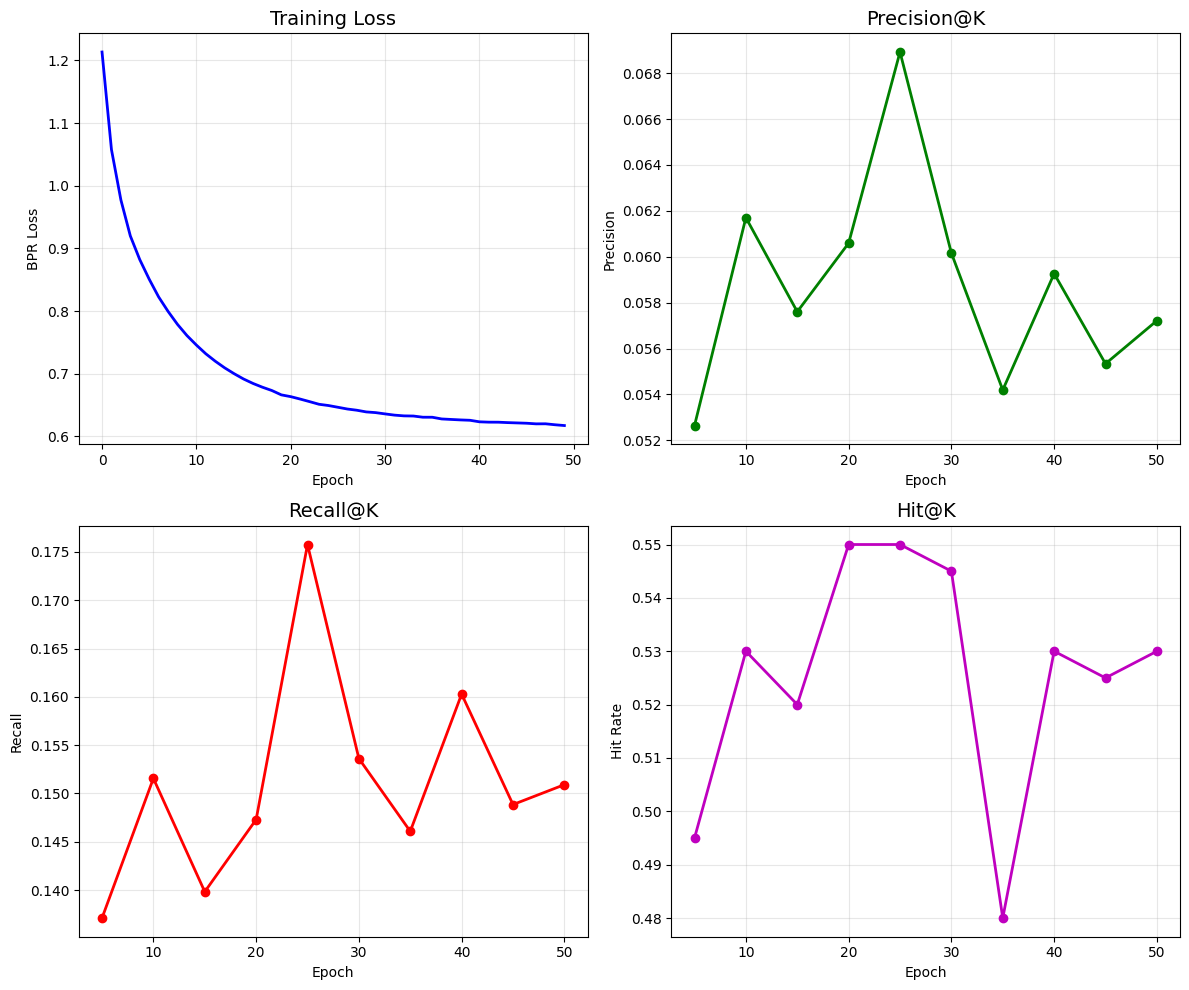

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].plot(history['loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Training Loss', fontsize=14)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('BPR Loss')
axes[0, 0].grid(alpha=0.3)

epochs_val = np.arange(5, EPOCHS+1, 5)[:len(history['precision'])]
axes[0, 1].plot(epochs_val, history['precision'], 'g-o', linewidth=2)
axes[0, 1].set_title('Precision@K', fontsize=14)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(epochs_val, history['recall'], 'r-o', linewidth=2)
axes[1, 0].set_title('Recall@K', fontsize=14)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(epochs_val, history['hit'], 'm-o', linewidth=2)
axes[1, 1].set_title('Hit@K', fontsize=14)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Hit Rate')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../cc_docs/ccb2_training.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Validation: AUC-ROC & Threshold Tuning

### Strategy:
1. Calculate AUC-ROC (primary metric for B ver)
2. Find optimal threshold by maximizing F1 score
3. Use this threshold for hybrid recommendation

In [27]:
# Load best model
model.load_state_dict(torch.load('../cc_models/ccb2_best.pt'))
model.eval()

with torch.no_grad():
    u_emb, i_emb = model(edge_index, edge_weight)

print("Step 1: Calculating AUC-ROC...")

# Positive samples: validation edges (rating >= 4)
val_u_gpu = torch.LongTensor(val_df['user_idx'].values).to(device)
val_i_gpu = torch.LongTensor(val_df['item_idx'].values).to(device)
val_pos_scores = (u_emb[val_u_gpu] * i_emb[val_i_gpu]).sum(dim=1).cpu().numpy()

# Negative samples: random pairs not in train/val/test
print("Generating negative samples (excluding all known edges)...")
val_test_edges = set()
for u, i in zip(val_df['user_idx'].values, val_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))
for u, i in zip(test_df['user_idx'].values, test_df['item_idx'].values):
    val_test_edges.add((int(u), int(i)))

n_neg_samples = len(val_df)
neg_users, neg_items = [], []
sample_count = 0
max_attempts = n_neg_samples * 100
attempts = 0

while sample_count < n_neg_samples and attempts < max_attempts:
    user_idx = np.random.randint(0, n_users)
    item_idx = np.random.randint(0, n_items)
    attempts += 1
    
    if item_idx not in user_train_items[user_idx] and (user_idx, item_idx) not in val_test_edges:
        neg_users.append(user_idx)
        neg_items.append(item_idx)
        sample_count += 1

neg_u_gpu = torch.LongTensor(neg_users).to(device)
neg_i_gpu = torch.LongTensor(neg_items).to(device)
val_neg_scores = (u_emb[neg_u_gpu] * i_emb[neg_i_gpu]).sum(dim=1).cpu().numpy()

# AUC-ROC
all_scores = np.concatenate([val_pos_scores, val_neg_scores])
all_labels = np.concatenate([np.ones(len(val_pos_scores)), np.zeros(len(val_neg_scores))])

val_auc_roc = roc_auc_score(all_labels, all_scores)
print(f"\nValidation AUC-ROC: {val_auc_roc:.4f}")
print(f"  → 1.0 = perfect separation, 0.5 = random")
print(f"  → Measures ability to distinguish good (rating >= 4) vs non-purchases")
print(f"\nScore distributions:")
print(f"  Positive (rating >= 4) scores: mean={val_pos_scores.mean():.4f}, std={val_pos_scores.std():.4f}")
print(f"  Negative scores: mean={val_neg_scores.mean():.4f}, std={val_neg_scores.std():.4f}")

Step 1: Calculating AUC-ROC...
Generating negative samples (excluding all known edges)...

Validation AUC-ROC: 0.9165
  → 1.0 = perfect separation, 0.5 = random
  → Measures ability to distinguish good (rating >= 4) vs non-purchases

Score distributions:
  Positive (rating >= 4) scores: mean=1.1114, std=0.6048
  Negative scores: mean=0.1120, std=0.3339


In [28]:
# Step 2: Threshold tuning (F1 maximization)
print("Step 2: Finding optimal threshold for F1 maximization...")

thresholds = np.linspace(all_scores.min(), all_scores.max(), 100)
best_f1, best_th = 0, 0
best_prec, best_rec = 0, 0

results_list = []
for th in thresholds:
    preds = (all_scores > th).astype(int)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)
    f1 = f1_score(all_labels, preds, zero_division=0)
    o_ratio = preds.mean()
    
    results_list.append({
        'threshold': th,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'o_ratio': o_ratio
    })
    
    if f1 > best_f1:
        best_f1 = f1
        best_th = th
        best_prec = prec
        best_rec = rec

print(f"\nOptimal Threshold (F1 Maximization):")
print(f"  Threshold: {best_th:.4f}")
print(f"  Precision: {best_prec:.4f}")
print(f"  Recall: {best_rec:.4f}")
print(f"  F1 Score: {best_f1:.4f}")

preds_at_best = (all_scores > best_th).astype(int)
o_ratio_best = preds_at_best.mean()
print(f"  O ratio: {o_ratio_best*100:.1f}%")

OPTIMAL_THRESHOLD = best_th

Step 2: Finding optimal threshold for F1 maximization...

Optimal Threshold (F1 Maximization):
  Threshold: 0.4295
  Precision: 0.8510
  Recall: 0.8705
  F1 Score: 0.8606
  O ratio: 51.1%


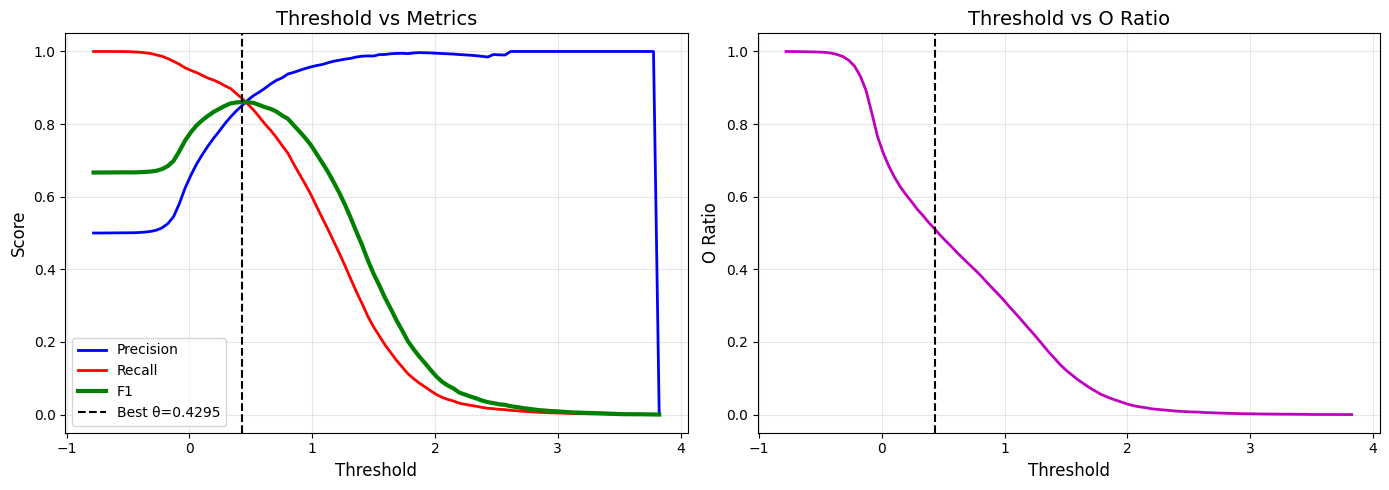


Threshold saved: OPTIMAL_THRESHOLD = 0.4295


In [29]:
# Visualization
results_df = pd.DataFrame(results_list)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(results_df['threshold'], results_df['precision'], 'b-', label='Precision', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['recall'], 'r-', label='Recall', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['f1'], 'g-', label='F1', linewidth=3)
axes[0].axvline(x=best_th, color='k', linestyle='--', label=f'Best θ={best_th:.4f}')
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Threshold vs Metrics', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(results_df['threshold'], results_df['o_ratio'], 'm-', linewidth=2)
axes[1].axvline(x=best_th, color='k', linestyle='--')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('O Ratio', fontsize=12)
axes[1].set_title('Threshold vs O Ratio', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../cc_docs/ccb2_threshold_tuning.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nThreshold saved: OPTIMAL_THRESHOLD = {OPTIMAL_THRESHOLD:.4f}")

## 9. Test Set Evaluation

In [30]:
# Test Top-K evaluation (reference)
test_prec, test_rec, test_hit = evaluate_user_wise_topk(model, test_df, sample_users=500)

print("Test Set Performance (Top-K only) - Reference:")
print(f"  Precision@K: {test_prec:.4f}")
print(f"  Recall@K: {test_rec:.4f}")
print(f"  Hit@K: {test_hit:.4f}")

Test Set Performance (Top-K only) - Reference:
  Precision@K: 0.0838
  Recall@K: 0.1819
  Hit@K: 0.6140


In [31]:
# Test AUC-ROC calculation
print("Calculating Test Set AUC-ROC...")

test_u_gpu = torch.LongTensor(test_df['user_idx'].values).to(device)
test_i_gpu = torch.LongTensor(test_df['item_idx'].values).to(device)
test_pos_scores = (u_emb[test_u_gpu] * i_emb[test_i_gpu]).sum(dim=1).cpu().numpy()

# Test negative samples
n_test_neg = len(test_df)
test_neg_scores = []
for _ in range(n_test_neg):
    user_idx = np.random.randint(0, n_users)
    item_idx = np.random.randint(0, n_items)
    while (item_idx in user_train_items[user_idx] or 
           (user_idx, item_idx) in val_test_edges):
        item_idx = np.random.randint(0, n_items)
    score = (u_emb[user_idx] * i_emb[item_idx]).sum().item()
    test_neg_scores.append(score)

test_neg_scores = np.array(test_neg_scores)

test_all_scores = np.concatenate([test_pos_scores, test_neg_scores])
test_all_labels = np.concatenate([np.ones(len(test_pos_scores)), np.zeros(len(test_neg_scores))])

test_auc_roc = roc_auc_score(test_all_labels, test_all_scores)

print(f"\nTest Set AUC-ROC: {test_auc_roc:.4f}")
print(f"Validation AUC-ROC: {val_auc_roc:.4f}")

# Test metrics with optimal threshold
test_preds = (test_all_scores > OPTIMAL_THRESHOLD).astype(int)
test_acc = (test_preds == test_all_labels).mean()
test_prec_th = precision_score(test_all_labels, test_preds, zero_division=0)
test_rec_th = recall_score(test_all_labels, test_preds, zero_division=0)
test_f1 = f1_score(test_all_labels, test_preds, zero_division=0)
test_o_ratio = test_preds.mean()

print(f"\nTest Set with Threshold={OPTIMAL_THRESHOLD:.4f}:")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec_th:.4f}")
print(f"  Recall: {test_rec_th:.4f}")
print(f"  F1 Score: {test_f1:.4f}")
print(f"  O Ratio: {test_o_ratio*100:.1f}%")

Calculating Test Set AUC-ROC...

Test Set AUC-ROC: 0.9179
Validation AUC-ROC: 0.9165

Test Set with Threshold=0.4295:
  Accuracy: 0.8598
  Precision: 0.8516
  Recall: 0.8714
  F1 Score: 0.8614
  O Ratio: 51.2%


## 10. Rating-based Recommendation (CCB2)

### CCB2 Strategy:
1. **Predict rating value** for each user-item pair (0.5 ~ 5.0)
2. If predicted_rating >= 4.0 → Recommend (O)
3. Otherwise → Don't recommend (X)
4. **No rating column needed in test set!**

In [32]:
def predict_rating_based(test_input_df, rating_threshold=4.0, verbose=True, show_rating=False):
    """
    ★ CCB2: Rating-based recommendation
    
    Predicts rating value for each user-item pair.
    If predicted_rating >= rating_threshold → Recommend (O)
    
    Args:
        test_input_df: Test data (user, item columns, rating column optional but IGNORED)
        rating_threshold: Threshold for recommendation (default 4.0)
        verbose: Print AGENTS.md format
        show_rating: Show predicted rating in output (for debugging)
    
    Returns:
        results_df: DataFrame with recommendations
    
    Output format follows AGENTS.md specification:
    ====================
    user   item   recommend
    1      166    O
    4      88     X
    ...
    ====================
    Total recommends = 123/200
    Not recommend = 77/200
    """
    model.eval()
    
    results = []
    stats = {'total_o': 0, 'total_items': 0}

    with torch.no_grad():
        for _, row in test_input_df.iterrows():
            user = row['user']
            item = row['item']

            # Unknown user/item → X
            if user not in user2idx or item not in item2idx:
                results.append({
                    'user': user,
                    'item': item,
                    'recommend': 'X',
                    'predicted_rating': None
                })
                stats['total_items'] += 1
                continue

            user_idx = user2idx[user]
            item_idx = item2idx[item]

            # Train에 있는 item → X
            if item_idx in user_train_items[user_idx]:
                results.append({
                    'user': user,
                    'item': item,
                    'recommend': 'X',
                    'predicted_rating': None
                })
                stats['total_items'] += 1
                continue

            # ★ CCB2: Predict rating value
            user_tensor = torch.tensor([user_idx], dtype=torch.long).to(device)
            item_tensor = torch.tensor([item_idx], dtype=torch.long).to(device)
            
            pred_rating = model.predict_rating(
                user_tensor, item_tensor,
                edge_index, edge_weight
            ).item()

            # ★ CCB2: Rating >= threshold → Recommend
            if pred_rating >= rating_threshold:
                recommend = 'O'
                stats['total_o'] += 1
            else:
                recommend = 'X'

            results.append({
                'user': user,
                'item': item,
                'recommend': recommend,
                'predicted_rating': pred_rating
            })
            stats['total_items'] += 1

    results_df = pd.DataFrame(results)

    # Print in AGENTS.md format
    if verbose:
        print("=" * 70)
        if show_rating:
            print(f"{'user':<10} {'item':<10} {'pred_rating':<12} {'recommend':<10}")
            for _, row in results_df.iterrows():
                pred_r = f"{row['predicted_rating']:.2f}" if row['predicted_rating'] is not None else "N/A"
                print(f"{row['user']:<10} {row['item']:<10} {pred_r:<12} {row['recommend']:<10}")
        else:
            print(f"{'user':<10} {'item':<10} {'recommend':<10}")
            for _, row in results_df.iterrows():
                print(f"{row['user']:<10} {row['item']:<10} {row['recommend']:<10}")
        print("=" * 70)
        print(f"Total recommends = {stats['total_o']}/{stats['total_items']}")
        print(f"Not recommend = {stats['total_items'] - stats['total_o']}/{stats['total_items']}")
        print()

    return results_df

## 11. Sample Prediction Test

In [33]:
# Test with sample1.csv
# ★ CCB2: Rating column in sample1.csv is IGNORED! We predict rating ourselves.
sample1 = pd.read_csv('../data/sample1.csv')

print("Sample1.csv Test (CCB2 - Rating Prediction):")
print(f"★ Note: Rating column in sample1.csv is IGNORED!")
print(f"★ We predict rating values ourselves")
print(f"Rating threshold: 4.0")
print()
print("Predictions with rating values:")
predictions1 = predict_rating_based(sample1, rating_threshold=4.0, verbose=True, show_rating=True)

Sample1.csv Test (CCB2 - Rating Prediction):
★ Note: Rating column in sample1.csv is IGNORED!
★ We predict rating values ourselves
Rating threshold: 4.0

Predictions with rating values:
user       item       pred_rating  recommend 
109        3745       3.24         X         
88         4447       3.21         X         
71         4306       4.73         O         
66         1747       3.45         X         
15         66934      4.99         O         
Total recommends = 2/5
Not recommend = 3/5



In [34]:
# Test with sample2.csv (no rating column)
sample2 = pd.read_csv('../data/sample2.csv')

print("Sample2.csv Test (CCB2 - Rating Prediction):")
print(f"★ No rating column needed! We predict rating values.")
print(f"Rating threshold: 4.0")
print()
print("Predictions with rating values:")
predictions2 = predict_rating_based(sample2, rating_threshold=4.0, verbose=True, show_rating=True)

Sample2.csv Test (CCB2 - Rating Prediction):
★ No rating column needed! We predict rating values.
Rating threshold: 4.0

Predictions with rating values:
user       item       pred_rating  recommend 
109.0      3745.0     3.24         X         
88.0       4447.0     3.21         X         
71.0       4306.0     4.73         O         
66.0       1747.0     3.45         X         
15.0       66934.0    4.99         O         
Total recommends = 2/5
Not recommend = 3/5



## 12. Final Summary

In [35]:
print("="*70)
print("CCB2 - Rating Prediction Approach (B ver, V9b successor)")
print("="*70)

print(f"\nModel Config:")
print(f"  Architecture: LightGCN")
print(f"  Embedding dim: {EMB_DIM}")
print(f"  Layers: {N_LAYERS}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nStrategy:")
print(f"  Ground Truth: Rating >= {GOOD_RATING_THRESHOLD} (quality-focused)")
print(f"  Graph: Rating-weighted (0.4 + 0.15 * rating)")
print(f"  Negative Sampling: Hard ({HARD_NEG_RATIO:.0%}) + Random ({1-HARD_NEG_RATIO:.0%})")
print(f"  Loss: BPR Loss")

print(f"\nData:")
print(f"  Total edges: {len(df):,}")
print(f"  Good purchases (rating >= {GOOD_RATING_THRESHOLD}): {n_good_purchases:,}")
print(f"  Train (all purchases): {len(train_df):,}")
print(f"  Val (good only): {len(val_df):,}")
print(f"  Test (good only): {len(test_df):,}")

print(f"\nOptimal Threshold (F1 Maximization):")
print(f"  Threshold: {OPTIMAL_THRESHOLD:.4f}")

print(f"\nTest Performance:")
print(f"  AUC-ROC: {test_auc_roc:.4f} ★ (primary metric)")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_prec_th:.4f}")
print(f"  Recall: {test_rec_th:.4f}")
print(f"  F1 Score: {test_f1:.4f}")

print(f"\nComparison with V9b target:")
print(f"  V9b AUC-ROC: 0.9264 | F1: 0.8718")
print(f"  ccb2 AUC-ROC: {test_auc_roc:.4f} | F1: {test_f1:.4f}")

print(f"\nModel saved to: ../cc_models/ccb2_best.pt")
print(f"Threshold for inference: {OPTIMAL_THRESHOLD:.4f}")
print("\nReady for final test set prediction!")

CCB2 - Rating Prediction Approach (B ver, V9b successor)

Model Config:
  Architecture: LightGCN
  Embedding dim: 32
  Layers: 2
  Parameters: 352,737

Strategy:
  Ground Truth: Rating >= 4 (quality-focused)
  Graph: Rating-weighted (0.4 + 0.15 * rating)
  Negative Sampling: Hard (50%) + Random (50%)
  Loss: BPR Loss

Data:
  Total edges: 105,139
  Good purchases (rating >= 4): 51,830
  Train (all purchases): 89,294
  Val (good only): 7,480
  Test (good only): 8,365

Optimal Threshold (F1 Maximization):
  Threshold: 0.4295

Test Performance:
  AUC-ROC: 0.9179 ★ (primary metric)
  Accuracy: 0.8598
  Precision: 0.8516
  Recall: 0.8714
  F1 Score: 0.8614

Comparison with V9b target:
  V9b AUC-ROC: 0.9264 | F1: 0.8718
  ccb2 AUC-ROC: 0.9179 | F1: 0.8614

Model saved to: ../cc_models/ccb2_best.pt
Threshold for inference: 0.4295

Ready for final test set prediction!


## 13. Final Test Inference (Uncomment when ready)

```python
# When professor provides test.csv:
final_test = pd.read_csv('../data/test.csv')
print(f"Using threshold: {OPTIMAL_THRESHOLD:.4f}")
final_predictions = predict_hybrid(final_test, OPTIMAL_THRESHOLD)
final_predictions.to_csv('../cc/ccb2_predictions.csv', index=False)
print(f"\nPredictions saved to ../cc/ccb2_predictions.csv")
```